# TTS Video Project Pipeline
This notebook covers all steps from input text, TTS voice synthesis, subtitle generation, audio/video concatenation, image processing, and final export for YouTube.

In [1]:
!pip install azure-cognitiveservices-speech pysubs2 pillow snownlp python-dotenv tqdm pyyaml


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [130]:
# cell 2
import os
import yaml
from dotenv import load_dotenv

# Set main working directory
main_dir = r"C:\Users\flyre\projects\myvideoprojects"
os.chdir(main_dir)
subdir = main_dir

# Load environment variables
load_dotenv()
AZURE_SPEECH_KEY = os.environ.get("AZURE_SPEECH_KEY")
AZURE_SPEECH_REGION = os.environ.get("AZURE_SPEECH_REGION")
MINIMAX_SPEECH_KEY = os.environ.get("MINIMAX_SPEECH_KEY")
if not AZURE_SPEECH_KEY or not AZURE_SPEECH_REGION or not MINIMAX_SPEECH_KEY:
    raise ValueError("Missing AZURE_SPEECH_KEY or AZURE_SPEECH_REGION or MINIMAX_SPEECH_KEY in .env file!")

# Load config.yaml if it exists, otherwise use empty config
if os.path.exists('config.yaml'):
    with open('config.yaml', encoding='utf-8') as f:
        config = yaml.safe_load(f)
else:
    config = {}

# Print basic project info
print("專案名稱:", config.get("project_title", config.get("title", "未設定")))
print("Current subdir:", subdir)
print("目前工作目錄：", os.getcwd())

專案名稱: test
Current subdir: C:\Users\flyre\projects\myvideoprojects
目前工作目錄： C:\Users\flyre\projects\myvideoprojects


In [172]:
# cell 3
import ipywidgets as widgets
from IPython.display import display, clear_output, Audio
import yaml
import os
from dotenv import load_dotenv
import requests
import tempfile

load_dotenv()

label_style = {'description_width': '120px'}
wide_layout = widgets.Layout(width='1100px')
wide_textarea_layout = widgets.Layout(width='1100px', height='250px')
wide_preview_textarea_layout = widgets.Layout(width='1100px', height='125px')

# Azure voices
azure_voice_options = [
    'zh-TW-YunJheNeural', 'zh-TW-HsiaoChenNeural', 'zh-CN-YunxiNeural',
    'en-US-JennyNeural', 'en-US-AriaNeural', 'en-US-GuyNeural',
    'ja-JP-NanamiNeural', 'ja-JP-KeitaNeural'
]

# MINIMAX accents and voices
minimax_accent_options = [
    ('中文-普通話', 'Chinese (Mandarin)'),
    ('英文', 'English'),
    ('日文', 'Japanese')
]
minimax_voice_dict = {
    'Chinese (Mandarin)': [
        'Chinese (Mandarin)_Warm_Bestie',
        'Chinese (Mandarin)_Lyrical_Voice',
        'Chinese (Mandarin)_Bright_Light',
        'Chinese (Mandarin)_Sweet_Girl',
        'Chinese (Mandarin)_Young_Man',
        'Chinese (Mandarin)_Deep_Dad',
        'Chinese (Mandarin)_Calm_Mom',
        'Chinese (Mandarin)_Narrator_Professional',
        'Chinese (Mandarin)_Narrator_Soft',
        'Chinese (Mandarin)_Child_Boy',
        'Chinese (Mandarin)_Child_Girl',
        'Chinese (Mandarin)_Elder_Grandpa',
        'Chinese (Mandarin)_Elder_Grandma',
        'Chinese (Mandarin)_News_Anchor',
        'Chinese (Mandarin)_Cartoon_Bear',
        'Chinese (Mandarin)_Cartoon_Duck',
        'Chinese (Mandarin)_Cartoon_Fox',
        'Chinese (Mandarin)_Cartoon_Robot'
    ],
    'English': [
        'English_Graceful_Lady',
        'English_Persuasive_Man'
    ],
    'Japanese': [
        'Japanese_Whisper_Belle'
    ]
}

# Input widgets
input_text_widget = widgets.Textarea(
    value='', description='文字內容:', style=label_style, layout=wide_textarea_layout
)
preview_text_widget = widgets.Textarea(
    value='', description='試聽文字:', style=label_style, layout=wide_preview_textarea_layout
)
preview_button = widgets.Button(description='語音試聽', button_style='info', layout=widgets.Layout(width='350px', height='60px'))
audio_output = widgets.Output(layout=wide_layout)
save_button = widgets.Button(description='確定儲存', button_style='success', layout=widgets.Layout(width='350px', height='60px'))
output = widgets.Output(layout=wide_layout)

tts_server_widget = widgets.Dropdown(
    options=[('Azure', 'azure'), ('MINIMAX', 'minimax')],
    value='azure', description='TTS伺服器:', style=label_style, layout=wide_layout
)

# Azure widgets
azure_voice_widget = widgets.Dropdown(
    options=azure_voice_options, value=azure_voice_options[0],
    description='Azure語音:', style=label_style, layout=wide_layout
)
azure_speed_widget = widgets.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.01, description='語速:', style=label_style, layout=wide_layout)
azure_pitch_widget = widgets.IntSlider(value=0, min=-12, max=12, step=1, description='語調:', style=label_style, layout=wide_layout)

# MINIMAX widgets
minimax_model_widget = widgets.Dropdown(
    options=['speech-02-hd', 'speech-2.5-hd-preview'], value='speech-02-hd', description='MINIMAX模型:', style=label_style, layout=wide_layout)
minimax_accent_widget = widgets.Dropdown(
    options=minimax_accent_options, value='Chinese (Mandarin)', description='MINIMAX腔調:', style=label_style, layout=wide_layout
)
minimax_voice_widget = widgets.Dropdown(
    options=minimax_voice_dict['Chinese (Mandarin)'], value=minimax_voice_dict['Chinese (Mandarin)'][0],
    description='MINIMAX語音:', style=label_style, layout=wide_layout
)
minimax_emotion_widget = widgets.Dropdown(
    options=['calm', 'happy', 'sad', 'angry', 'fearful', 'disgusted', 'surprised'],
    value='calm', description='MINIMAX情感:', style=label_style, layout=wide_layout)
minimax_vol_widget = widgets.FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='MINIMAX音量:', style=label_style, layout=wide_layout)
minimax_speed_widget = widgets.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.01, description='語速:', style=label_style, layout=wide_layout)
minimax_pitch_widget = widgets.IntSlider(value=0, min=-12, max=12, step=1, description='語調:', style=label_style, layout=wide_layout)
minimax_audio_format_widget = widgets.Dropdown(
    options=['mp3', 'wav'], value='mp3', description='MINIMAX音檔格式:', style=label_style, layout=wide_layout)
minimax_sample_rate_widget = widgets.Dropdown(
    options=[32000, 44100], value=32000, description='MINIMAX取樣率:', style=label_style, layout=wide_layout)
minimax_bitrate_widget = widgets.Dropdown(
    options=[128000, 256000], value=128000, description='MINIMAX比特率:', style=label_style, layout=wide_layout)
minimax_channel_widget = widgets.Dropdown(
    options=[1, 2], value=1, description='MINIMAX聲道:', style=label_style, layout=wide_layout)

# Accent change updates voice list
def update_minimax_voices(*args):
    accent = minimax_accent_widget.value
    minimax_voice_widget.options = minimax_voice_dict[accent]
    minimax_voice_widget.value = minimax_voice_dict[accent][0]
minimax_accent_widget.observe(update_minimax_voices, names='value')

# --- Project info widgets ---
project_title_widget = widgets.Text(value='test', description='專案名稱:', style=label_style, layout=wide_layout)
project_author_widget = widgets.Text(value='', description='作者:', style=label_style, layout=wide_layout)
bgm_volume_widget = widgets.FloatSlider(value=0.3, min=0, max=1, step=0.01, description='BGM音量:', style=label_style, layout=wide_layout)
attribution_widget = widgets.Text(value='', description='版權說明:', style=label_style, layout=wide_layout)
subtitle_font_widget = widgets.Text(value='NotoSansCJKtc-Regular.otf', description='字幕字型:', style=label_style, layout=wide_layout)
subtitle_fontsize_widget = widgets.IntSlider(value=30, min=10, max=80, step=1, description='字幕字體大小:', style=label_style, layout=wide_layout)
video_resolution_widget = widgets.Text(value='1920,1080', description='影片解析度:', style=label_style, layout=wide_layout)

# --- Dynamically list images and audio from ammunition directory ---
def get_ammunition_files(extension_list):
    files = []
    if os.path.isdir("ammunition"):
        for fname in os.listdir("ammunition"):
            if any(fname.lower().endswith(ext) for ext in extension_list):
                files.append(fname)
    return files if files else ["(無符合檔案)"]

background_image_options = get_ammunition_files(['.jpg', '.jpeg', '.png', '.bmp', '.webp'])
bgm_audio_options = get_ammunition_files(['.mp3', '.wav', '.aac', '.m4a', '.flac', '.ogg'])

background_file_widget = widgets.Dropdown(
    options=background_image_options,
    value=background_image_options[0],
    description='背景檔:', style=label_style, layout=wide_layout
)
bgm_file_widget = widgets.Dropdown(
    options=bgm_audio_options,
    value=bgm_audio_options[0],
    description='BGM檔:', style=label_style, layout=wide_layout
)

thumbnail_file_widget = widgets.Text(value='thumbnail.jpg', description='縮圖檔:', style=label_style, layout=wide_layout)
text_file_widget = widgets.Text(value='text.txt', description='文字檔:', style=label_style, layout=wide_layout)

project_info_box = widgets.VBox([
    project_title_widget, project_author_widget, bgm_volume_widget,
    attribution_widget, subtitle_font_widget, subtitle_fontsize_widget,
    video_resolution_widget, background_file_widget, bgm_file_widget,
    thumbnail_file_widget, text_file_widget
])

# --- Dynamic param box ---
param_box = widgets.VBox()
def update_param_box(*args):
    if tts_server_widget.value == 'azure':
        param_box.children = [azure_voice_widget, azure_speed_widget, azure_pitch_widget]
    else:
        param_box.children = [
            minimax_model_widget, minimax_accent_widget, minimax_voice_widget, minimax_emotion_widget,
            minimax_vol_widget, minimax_speed_widget, minimax_pitch_widget,
            minimax_audio_format_widget, minimax_sample_rate_widget, minimax_bitrate_widget, minimax_channel_widget
        ]
update_param_box()
tts_server_widget.observe(update_param_box, names='value')

# ---- TTS Functions ----
def azure_tts_api(text, voice, speed, pitch):
    AZURE_SPEECH_KEY = os.environ.get("AZURE_SPEECH_KEY")
    AZURE_SPEECH_REGION = os.environ.get("AZURE_SPEECH_REGION")
    if not AZURE_SPEECH_KEY or not AZURE_SPEECH_REGION:
        print("Azure API key 或 region 未設定。")
        return None
    try:
        import azure.cognitiveservices.speech as speechsdk
        speech_config = speechsdk.SpeechConfig(subscription=AZURE_SPEECH_KEY, region=AZURE_SPEECH_REGION)
        speech_config.speech_synthesis_voice_name = voice
        synthesizer = speechsdk.SpeechSynthesizer(speech_config=speech_config)
        result = synthesizer.speak_text_async(text).get()
        if result.reason == speechsdk.ResultReason.Canceled:
            cancellation_details = speechsdk.CancellationDetails(result)
            print(f"Azure TTS失敗: {cancellation_details.reason}\n{cancellation_details.error_details}")
            return None
        if result.reason == speechsdk.ResultReason.SynthesizingAudioCompleted:
            tf = tempfile.NamedTemporaryFile(delete=False, suffix='.wav')
            tf.write(result.audio_data)
            tf.close()
            return tf.name
        else:
            print(f"Azure TTS失敗: {getattr(result, 'error_details', str(result.reason))}")
    except Exception as e:
        print("Azure TTS執行錯誤:", str(e))
    return None

def minimax_tts_api(text, model, voice, emotion, vol, speed, pitch, audio_format, sample_rate, bitrate, channel):
    MINIMAX_SPEECH_KEY = os.getenv('MINIMAX_SPEECH_KEY')
    url = f"https://api.minimax.io/v1/t2a_v2?GroupId=1982992498867311582"
    headers = {
        "Authorization": f"Bearer {MINIMAX_SPEECH_KEY}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": model,
        "text": text,
        "voice_setting": {
            "voice_id": voice,
            "speed": speed,
            "vol": vol,
            "pitch": pitch,
            "emotion": emotion
        },
        "audio_setting": {
            "sample_rate": sample_rate,
            "bitrate": bitrate,
            "format": audio_format,
            "channel": channel
        },
        "output_format": "url",
        "language_boost": "auto",
        "subtitle_enable": False
    }
    try:
        r = requests.post(url, headers=headers, json=payload)
        if r.status_code == 200:
            data = r.json()
            base_resp = data.get("base_resp", {})
            if base_resp.get("status_code") == 0:
                audio_url = data.get("data", {}).get("audio")
                if audio_url:
                    r2 = requests.get(audio_url)
                    if r2.status_code == 200:
                        with tempfile.NamedTemporaryFile(delete=False, suffix='.'+audio_format) as tf:
                            tf.write(r2.content)
                            temp_audio_path = tf.name
                        return temp_audio_path
                    else:
                        print("MINIMAX音檔下載失敗：", r2.status_code)
                else:
                    print("MINIMAX未取得音檔URL，請檢查API回應！")
            else:
                print("MINIMAX API錯誤：", base_resp.get("status_msg"))
        else:
            print("MINIMAX TTS API失敗，狀態碼：", r.status_code)
            print("回應：", r.text[:300])
            print("Payload used:\n", payload)
    except Exception as e:
        print("MINIMAX TTS試聽錯誤：", e)
    return None

def on_preview_clicked(b):
    with audio_output:
        audio_output.clear_output()
        preview_text = preview_text_widget.value.strip()
        if not preview_text:
            print("請輸入欲試聽的語音文字！")
            return
        if tts_server_widget.value == 'azure':
            temp_audio_path = azure_tts_api(
                preview_text, azure_voice_widget.value, azure_speed_widget.value, azure_pitch_widget.value)
        else:
            temp_audio_path = minimax_tts_api(
                preview_text, minimax_model_widget.value, minimax_voice_widget.value,
                minimax_emotion_widget.value, minimax_vol_widget.value,
                minimax_speed_widget.value, minimax_pitch_widget.value,
                minimax_audio_format_widget.value, minimax_sample_rate_widget.value,
                minimax_bitrate_widget.value, minimax_channel_widget.value)
        if temp_audio_path:
            display(Audio(temp_audio_path, autoplay=True))
            print(f"{tts_server_widget.value}語音試聽成功！")

preview_button.on_click(on_preview_clicked)

def on_save_clicked(b):
    # Enforce project_title is not empty
    project_title_value = project_title_widget.value.strip() if project_title_widget.value.strip() else "test"
    project_title_widget.value = project_title_value  # update widget if needed

    config = {
        'input_text': input_text_widget.value,
        'preview_text': preview_text_widget.value,
        'tts_server': tts_server_widget.value,
        'azure_voice': azure_voice_widget.value,
        'azure_speed': azure_speed_widget.value,
        'azure_pitch': azure_pitch_widget.value,
        'minimax_model': minimax_model_widget.value,
        'minimax_accent': minimax_accent_widget.value,
        'minimax_voice': minimax_voice_widget.value,
        'minimax_emotion': minimax_emotion_widget.value,
        'minimax_vol': minimax_vol_widget.value,
        'minimax_speed': minimax_speed_widget.value,
        'minimax_pitch': minimax_pitch_widget.value,
        'minimax_audio_format': minimax_audio_format_widget.value,
        'minimax_sample_rate': minimax_sample_rate_widget.value,
        'minimax_bitrate': minimax_bitrate_widget.value,
        'minimax_channel': minimax_channel_widget.value,
        'project_title': project_title_value,
        'project_author': project_author_widget.value,
        'bgm_volume': bgm_volume_widget.value,
        'attribution': attribution_widget.value,
        'subtitle_font': subtitle_font_widget.value,
        'subtitle_fontsize': subtitle_fontsize_widget.value,
        'video_resolution': video_resolution_widget.value,
        'background': background_file_widget.value,
        'bgm': bgm_file_widget.value,
        'thumbnail': thumbnail_file_widget.value,
        'text': text_file_widget.value,
    }
    with output:
        output.clear_output()
        yaml.safe_dump(config, open('config.yaml', 'w', encoding='utf-8'), allow_unicode=True)
        print('設定已儲存到 config.yaml！')
        print(config)
        if project_title_value == "test":
            print("⚠️ 專案名稱為 test，請在專案開始前確認填寫正確名稱。")

save_button.on_click(on_save_clicked)

# ---- Display all widgets ----
display(
    input_text_widget,
    preview_text_widget,
    preview_button,
    audio_output,
    tts_server_widget,
    param_box,
    project_info_box,
    save_button,
    output
)

Textarea(value='', description='文字內容:', layout=Layout(height='250px', width='1100px'), style=TextStyle(descrip…

Textarea(value='', description='試聽文字:', layout=Layout(height='125px', width='1100px'), style=TextStyle(descrip…

Button(button_style='info', description='語音試聽', layout=Layout(height='60px', width='350px'), style=ButtonStyle…

Output(layout=Layout(width='1100px'))

Dropdown(description='TTS伺服器:', layout=Layout(width='1100px'), options=(('Azure', 'azure'), ('MINIMAX', 'minim…

Button(button_style='success', description='確定儲存', layout=Layout(height='60px', width='350px'), style=ButtonSt…

Output(layout=Layout(width='1100px'))

In [179]:
# cell 4-8
import os
import yaml
import shutil
import datetime
import re
from snownlp import SnowNLP
import subprocess
from tqdm.notebook import tqdm

print("\n=== STEP 1: Load config and project info ===")
# ---- Load config ----
try:
    with open('config.yaml', encoding='utf-8') as f:
        config = yaml.safe_load(f)
except Exception as e:
    print(f"[ERROR] Failed to load config.yaml: {e}")
    raise

# ---- Get info from config ----
project_title = config.get('project_title', config.get('title', 'My YouTube Video'))
project_author = config.get('project_author', 'Anonymous')
bgm_volume = config.get('bgm_volume', 0.3)
attribution = config.get('attribution', 'Assets used under free license. See description.')

# ---- Text file and sentences ----
text_file = config.get('text', 'text.txt')
input_text = config.get('input_text', '')
try:
    with open(text_file, 'w', encoding='utf-8') as f:
        f.write(input_text)
    with open(text_file, 'r', encoding='utf-8') as f:
        sentences = [line.strip() for line in f if line.strip()]
except Exception as e:
    print(f"[ERROR] Failed to read/write text file: {e}")
    raise

# ---- TTS params ----
tts_server = config.get('tts_server', 'azure')
azure_voice = config.get('azure_voice', '')
azure_speed = config.get('azure_speed', 1.0)
azure_pitch = config.get('azure_pitch', 0)
minimax_model = config.get('minimax_model', '')
minimax_accent = config.get('minimax_accent', '')
minimax_voice = config.get('minimax_voice', '')
minimax_emotion = config.get('minimax_emotion', '')
minimax_vol = config.get('minimax_vol', 1.0)
minimax_speed = config.get('minimax_speed', 1.0)
minimax_pitch = config.get('minimax_pitch', 0)
minimax_audio_format = config.get('minimax_audio_format', 'mp3')
minimax_sample_rate = config.get('minimax_sample_rate', 32000)
minimax_bitrate = config.get('minimax_bitrate', 128000)
minimax_channel = config.get('minimax_channel', 1)

subtitle_font = config.get('subtitle_font', 'NotoSansCJKtc-Regular.otf')
subtitle_fontsize = config.get('subtitle_fontsize', 30)
video_resolution = config.get('video_resolution', [1920, 1080])
if not (isinstance(video_resolution, (tuple, list)) and len(video_resolution) == 2):
    print("Invalid video_resolution, using default (1920, 1080).")
    video_resolution = (1920, 1080)
else:
    video_resolution = tuple(video_resolution)

background_file = config.get('background', 'background.jpg')
bgm_file = config.get('bgm', 'bgm.mp3')
thumbnail_file = config.get('thumbnail', 'thumbnail.jpg')

required_files = [background_file, bgm_file, text_file, subtitle_font, thumbnail_file]
for fname in required_files:
    if not os.path.exists(fname):
        print(f"[WARNING] Missing file: {fname}")

print("="*30)
print(f"已載入 {len(sentences)} 句子，來源: {text_file}")
print(f"TTS server: {tts_server}")
if tts_server == 'azure':
    print(f"Azure語音: {azure_voice}, 語速: {azure_speed}, 語調: {azure_pitch}")
elif tts_server == 'minimax':
    print(f"MINIMAX模型: {minimax_model}, 腔調: {minimax_accent}, 語音: {minimax_voice}, 情感: {minimax_emotion}")
    print(f"音量: {minimax_vol}, 語速: {minimax_speed}, 語調: {minimax_pitch}")
    print(f"音檔: {minimax_audio_format}, 取樣率: {minimax_sample_rate}, 比特率: {minimax_bitrate}, 聲道: {minimax_channel}")
print(f"字幕字型: {subtitle_font}, 字體大小: {subtitle_fontsize}")
print(f"影片解析度: {video_resolution}")
print(f"背景檔: {background_file}")
print(f"BGM檔: {bgm_file}")
print(f"縮圖檔: {thumbnail_file}")
print("="*30)

print("\n=== STEP 2: Prepare subdir and copy assets ===")
today = datetime.datetime.now().strftime("%Y%m%d")
safe_title = re.sub(r'[\\/:*?"<>|\n\r\t]', '', project_title)[:20]
subdir = os.path.join(os.getcwd(), f"{today}_{safe_title}")

try:
    if not os.path.exists(subdir):
        os.makedirs(subdir)
except Exception as e:
    print(f"[ERROR] Failed to create subdir: {e}")
    raise

for fname in required_files:
    target = os.path.join(subdir, os.path.basename(fname))
    try:
        if not os.path.exists(target) or not os.path.samefile(fname, target):
            shutil.copy2(fname, target)
    except Exception as e:
        print(f"[ERROR] Failed to copy {fname} to {target}: {e}")

print(f"All required files are available in subdir.")

print("\n=== STEP 3: Sentence segmentation and cleaning ===")
try:
    with open(os.path.join(subdir, "text.txt"), encoding="utf-8") as f:
        text = f.read().strip()
except Exception as e:
    print(f"[ERROR] Failed to read {os.path.join(subdir, 'text.txt')}: {e}")
    text = ""

def is_pronounceable(s):
    return bool(re.search(r'[\u4e00-\u9fffA-Za-z0-9]', s))

def clean_markdown(s):
    s = re.sub(r"^[#\-\*\s>]+", "", s)
    s = re.sub(r"(\*|`|_|>|#|\[|\]|\(|\)|\-|~|=|>)", "", s)
    s = re.sub(r"[「」]", "", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

try:
    sentences = [s.strip() for s in SnowNLP(text).sentences if s.strip()]
except Exception as e:
    print(f"[ERROR] SnowNLP sentence segmentation failed: {e}")
    sentences = [text] if text else []

sentences = [clean_markdown(s) for s in sentences if is_pronounceable(s)]
sentences = [s for s in sentences if is_pronounceable(s)]

print(f"Total sentences after filtering: {len(sentences)}")
for idx, s in enumerate(sentences):
    print(f"{idx}: '{s}'")

print("\n=== STEP 4: TTS synthesis ===")
audio_files, durations, error_log = [], [], []
failed_sentences = []
max_retries = 3

print(f"subdir for TTS synthesis: {subdir} ({type(subdir)})")
if tts_server == 'azure':
    try:
        import azure.cognitiveservices.speech as speechsdk
        AZURE_SPEECH_KEY = os.environ.get("AZURE_SPEECH_KEY")
        AZURE_SPEECH_REGION = os.environ.get("AZURE_SPEECH_REGION")
        print(f"[CHECK] Azure voice_id (voice_name) used for synthesis: {azure_voice}")
        speech_config = speechsdk.SpeechConfig(subscription=AZURE_SPEECH_KEY, region=AZURE_SPEECH_REGION)
        speech_config.speech_synthesis_voice_name = azure_voice
        speech_config.set_speech_synthesis_output_format(
            speechsdk.SpeechSynthesisOutputFormat.Audio16Khz32KBitRateMonoMp3
        )
        for i, sentence in enumerate(tqdm(sentences, desc="Synthesizing TTS (Azure)")):
            mp3_fname = os.path.join(subdir, f"voice_{i}.mp3")
            success = False
            for attempt in range(max_retries):
                try:
                    ssml = f"""<speak version='1.0' xml:lang='zh-TW'>
  <voice name='{azure_voice}'>
    <prosody rate='{azure_speed}' pitch='{azure_pitch}'>{sentence}</prosody>
  </voice>
</speak>"""
                    print(f"[CHECK] Synthesizing sentence {i} with Azure voice: {azure_voice}")
                    audio_config = speechsdk.audio.AudioOutputConfig(filename=mp3_fname)
                    synthesizer = speechsdk.SpeechSynthesizer(speech_config=speech_config, audio_config=audio_config)
                    result = synthesizer.speak_ssml_async(ssml).get()
                    if result.reason == speechsdk.ResultReason.SynthesizingAudioCompleted:
                        if os.path.exists(mp3_fname) and os.path.getsize(mp3_fname) > 0:
                            r = subprocess.run([
                                "ffprobe", "-v", "error", "-show_entries",
                                "format=duration", "-of", "default=noprint_wrappers=1:nokey=1", mp3_fname
                            ], capture_output=True)
                            try:
                                duration_val = float(r.stdout.decode().strip())
                                durations.append(duration_val)
                                audio_files.append(mp3_fname)
                                success = True
                                break
                            except ValueError:
                                error_log.append(f"Could not get duration for {mp3_fname}")
                        else:
                            error_log.append(f"File not created or empty: {mp3_fname}")
                    else:
                        error_log.append(
                            f"Synthesis failed for sentence {i}: {result.reason} Details: {getattr(result, 'error_details', '')}"
                        )
                except Exception as e:
                    error_log.append(f"Exception for sentence {i} try {attempt+1}: {str(e)}")
            if not success:
                failed_sentences.append((i, sentence))
    except Exception as e:
        print(f"[ERROR] Azure TTS synthesis failed: {e}")
elif tts_server == 'minimax':
    try:
        import requests
        MINIMAX_SPEECH_KEY = os.getenv('MINIMAX_SPEECH_KEY')
        print(f"[CHECK] MINIMAX voice_id (voice_name) used for synthesis: {minimax_voice}")
        url = "https://api.minimax.io/v1/t2a_v2?GroupId=1982992498867311582"
        headers = {
            "Authorization": f"Bearer {MINIMAX_SPEECH_KEY}",
            "Content-Type": "application/json"
        }
        for i, sentence in enumerate(tqdm(sentences, desc="Synthesizing TTS (MINIMAX)")):
            out_fname = os.path.join(subdir, f"voice_{i}.{minimax_audio_format}")
            payload = {
                "model": minimax_model,
                "text": sentence,
                "voice_setting": {
                    "voice_id": minimax_voice,
                    "speed": minimax_speed,
                    "vol": minimax_vol,
                    "pitch": minimax_pitch,
                    "emotion": minimax_emotion
                },
                "audio_setting": {
                    "sample_rate": minimax_sample_rate,
                    "bitrate": minimax_bitrate,
                    "format": minimax_audio_format,
                    "channel": minimax_channel
                },
                "output_format": "url",
                "language_boost": "auto",
                "subtitle_enable": False
            }
            print(f"[CHECK] Synthesizing sentence {i} with MINIMAX voice_id: {minimax_voice}")
            success = False
            for attempt in range(max_retries):
                try:
                    r = requests.post(url, headers=headers, json=payload)
                    if r.status_code == 200:
                        data = r.json()
                        base_resp = data.get("base_resp", {})
                        if base_resp.get("status_code") == 0:
                            audio_url = data.get("data", {}).get("audio")
                            if audio_url:
                                r2 = requests.get(audio_url)
                                if r2.status_code == 200:
                                    with open(out_fname, 'wb') as f:
                                        f.write(r2.content)
                                    rprobe = subprocess.run([
                                        "ffprobe", "-v", "error", "-show_entries",
                                        "format=duration", "-of", "default=noprint_wrappers=1:nokey=1", out_fname
                                    ], capture_output=True)
                                    try:
                                        duration_val = float(rprobe.stdout.decode().strip())
                                        durations.append(duration_val)
                                        audio_files.append(out_fname)
                                        success = True
                                        break
                                    except ValueError:
                                        error_log.append(f"Could not get duration for {out_fname}")
                                else:
                                    error_log.append(f"MINIMAX音檔下載失敗: {r2.status_code}")
                            else:
                                error_log.append("MINIMAX API未取得音檔URL")
                        else:
                            error_log.append("MINIMAX API錯誤: " + str(base_resp.get("status_msg", "")))
                    else:
                        error_log.append(f"MINIMAX TTS HTTP錯誤: {r.status_code}")
                except Exception as e:
                    error_log.append(f"Exception for sentence {i} try {attempt+1}: {str(e)}")
            if not success:
                failed_sentences.append((i, sentence))
    except Exception as e:
        print(f"[ERROR] MINIMAX TTS synthesis failed: {e}")

print("TTS synthesis complete. Valid files:", len(audio_files))
if error_log:
    print("Errors encountered:\n", "\n".join(error_log))
if failed_sentences:
    print("Failed sentences:")
    for idx, s in failed_sentences:
        print(f"Sentence {idx}: '{s}'")

print("\n=== STEP 5: Validate and concatenate audio files ===")
valid_sentences = []
valid_audio_files = []
valid_durations = []

for i, sentence in enumerate(sentences):
    mp3_fname = os.path.join(subdir, f"voice_{i}.mp3")
    if os.path.exists(mp3_fname) and os.path.getsize(mp3_fname) > 0:
        r = subprocess.run([
            "ffprobe", "-v", "error", "-show_entries",
            "format=duration", "-of", "default=noprint_wrappers=1:nokey=1", mp3_fname
        ], capture_output=True)
        try:
            duration_val = float(r.stdout.decode().strip())
            if duration_val > 0.01 and duration_val < 30:
                valid_durations.append(duration_val)
                valid_audio_files.append(mp3_fname)
                valid_sentences.append(sentence)
                print(f"OK: {i}: '{sentence}' ({duration_val:.2f}s)")
            else:
                print(f"Skipped {i}: '{sentence}' - duration {duration_val:.2f}s")
        except Exception as e:
            print(f"Error reading duration for {mp3_fname}: {e}")
    else:
        print(f"Missing or empty audio: {i}: '{sentence}'")

print(f"\nKept {len(valid_audio_files)} valid audio files and sentences")
if valid_sentences and valid_sentences[-1] == sentences[-1]:
    print("✅ Last sentence included:", valid_sentences[-1])
else:
    print("❌ Last sentence missing! Check synthesis and validation steps.")

files_txt = os.path.join(subdir, "files.txt")
try:
    with open(files_txt, "w", encoding="utf-8") as f:
        for af in valid_audio_files:
            f.write(f"file '{af}'\n")
except Exception as e:
    print(f"[ERROR] Failed to write files.txt: {e}")

voice_mp3 = os.path.join(subdir, "voice.mp3")
concat_result = subprocess.run(
    ["ffmpeg", "-y", "-f", "concat", "-safe", "0", "-i", files_txt, "-c", "copy", voice_mp3],
    capture_output=True
)
if concat_result.returncode != 0:
    print("[FFmpeg Error] Failed to concatenate audio files.")
    print(concat_result.stderr.decode())
else:
    print("Concatenated voice.mp3 created successfully.")

print("="*40)
print(f"專案名稱: {project_title}")
print(f"Current subdir: {subdir}")
print(f"目前工作目錄：{os.getcwd()}")
print("="*40)


=== STEP 1: Load config and project info ===
Invalid video_resolution, using default (1920, 1080).
已載入 0 句子，來源: text.txt
TTS server: azure
Azure語音: zh-TW-YunJheNeural, 語速: 1.0, 語調: 0
字幕字型: NotoSansCJKtc-Regular.otf, 字體大小: 30
影片解析度: (1920, 1080)
背景檔: background.jpg
BGM檔: bgm.mp3
縮圖檔: thumbnail.jpg

=== STEP 2: Prepare subdir and copy assets ===
All required files are available in subdir.

=== STEP 3: Sentence segmentation and cleaning ===
[ERROR] SnowNLP sentence segmentation failed: division by zero
Total sentences after filtering: 0

=== STEP 4: TTS synthesis ===
subdir for TTS synthesis: C:\Users\flyre\projects\myvideoprojects\20251031_test (<class 'str'>)
[CHECK] Azure voice_id (voice_name) used for synthesis: zh-TW-YunJheNeural


Synthesizing TTS (Azure): 0it [00:00, ?it/s]

TTS synthesis complete. Valid files: 0

=== STEP 5: Validate and concatenate audio files ===

Kept 0 valid audio files and sentences
❌ Last sentence missing! Check synthesis and validation steps.
[FFmpeg Error] Failed to concatenate audio files.
ffmpeg version 8.0-full_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 15.2.0 (Rev8, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-lcms2 --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-libdvdnav --enable-libdvdread --enable-sdl2 --enable-libaribb24 --enable-libaribcaption --enable-libdav1d --enable-libdavs2 --enable-libopenjpeg --enable-libquirc --enable-libuavs3d --enable-libxevd --enable-libzvbi --

In [175]:
# cell 8.1
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
import yaml
import subprocess

# --- Ensure main_dir is defined ---
try:
    main_dir
except NameError:
    main_dir = os.getcwd()

# --- Set up asset directory ---
ammunition_dir = os.path.join(main_dir, "ammunition")

def get_duration(path):
    if not os.path.exists(path):
        return None
    result = subprocess.run([
        "ffprobe", "-v", "error", "-show_entries",
        "format=duration", "-of", "default=noprint_wrappers=1:nokey=1", path
    ], capture_output=True)
    try:
        return float(result.stdout.decode().strip())
    except Exception:
        return None

all_files = os.listdir(ammunition_dir)
image_files = [f for f in all_files if f.lower().endswith(('.jpg', '.png'))]
video_files = [f for f in all_files if f.lower().endswith(('.mp4', '.mov', '.avi'))]
music_files = [f for f in all_files if f.lower().endswith(('.mp3', '.wav'))]

video_info = []
for vf in video_files:
    path = os.path.join(ammunition_dir, vf)
    dur = get_duration(path)
    video_info.append((vf, dur))

video_options = ["(無)"] + [f"{fn} ({d:.2f}s)" if d else fn for fn, d in video_info]
video_map = {f"{fn} ({d:.2f}s)": fn for fn, d in video_info if d}
image_options = ["(無)"] + image_files

# --- Use valid_audio_files from previous cell ---
audio_durations = [get_duration(valid_audio_files[i]) for i in range(len(valid_sentences))]
accum_durations = []
running_total = 0.0
for d in audio_durations:
    running_total += d if d else 0
    accum_durations.append(running_total)

# --- Prepare vertical columns ---
sentence_labels = []
bg_selectors = []
vid_selectors = []

for i, sentence in enumerate(valid_sentences):
    aud_dur = audio_durations[i] if i < len(audio_durations) and audio_durations[i] else 0
    accum_dur = accum_durations[i] if i < len(accum_durations) else 0
    label_txt = f"{i+1}. {sentence[:40]} (audio: {aud_dur:.2f}s, total: {accum_dur:.2f}s)"
    sentence_label = widgets.Label(label_txt)
    bg_dd = widgets.Dropdown(options=image_options, value="(無)", description="")
    vid_dd = widgets.Dropdown(options=video_options, value="(無)", description="")
    sentence_labels.append(sentence_label)
    bg_selectors.append(bg_dd)
    vid_selectors.append(vid_dd)

# --- Column Headers ---
col1_title = widgets.HTML("<b>句子 / 時間</b>")
col2_title = widgets.HTML("<b>背景圖片</b>")
col3_title = widgets.HTML("<b>影片剪輯</b>")

sentence_labels_col = widgets.VBox([col1_title] + sentence_labels)
bg_selectors_col = widgets.VBox([col2_title] + bg_selectors)
vid_selectors_col = widgets.VBox([col3_title] + vid_selectors)

table_ui = widgets.HBox([sentence_labels_col, bg_selectors_col, vid_selectors_col])

instructions = widgets.HTML("""
<b>分鏡表編輯器（直欄對齊）</b><br>
左欄：句子及語音長度<br>
中欄：背景圖片選擇（有注入時即選擇，否則留空）<br>
右欄：影片選擇（有注入時即選擇，否則留空）<br>
完成後點「儲存分鏡表」。如有時長不符將提示警告。
""")

display(instructions, table_ui)

# --- Save Button + Output ---
save_btn = widgets.Button(description="儲存分鏡表", button_style="success")
output = widgets.Output()

def save_plan(b):
    with output:
        output.clear_output()
        visual_plan = []
        warnings = []
        for i, sentence in enumerate(valid_sentences):
            bg = bg_selectors[i].value if bg_selectors[i].value != "(無)" else None
            vid_label = vid_selectors[i].value
            vid = None
            vid_dur = None
            if vid_label != "(無)":
                if vid_label in video_map:
                    vid = video_map[vid_label]
                    vid_dur = get_duration(os.path.join(ammunition_dir, vid))
                else:
                    vid = vid_label.split(" (")[0]
                    vid_dur = get_duration(os.path.join(ammunition_dir, vid))
            audio_fname = valid_audio_files[i]
            audio_dur = audio_durations[i] if i < len(audio_durations) and audio_durations[i] else 0
            accum_dur = accum_durations[i] if i < len(accum_durations) else 0
            if vid and vid_dur and audio_dur and abs(vid_dur - audio_dur) > 1.0:
                warnings.append(f"⚠️ 句{i+1}影片({vid_dur:.2f}s)與語音({audio_dur:.2f}s)時長不符。")
            visual_plan.append({
                "sentence_idx": i,
                "sentence": sentence,
                "audio_file": audio_fname,
                "audio_duration": audio_dur,
                "accum_duration": accum_dur,
                "background": bg,
                "video_clip": vid,
                "video_duration": vid_dur
            })
        visual_plan_path = os.path.join(subdir, "visual_plan.yaml")
        with open(visual_plan_path, "w", encoding="utf-8") as f:
            yaml.safe_dump(visual_plan, f, allow_unicode=True)
        print(f"分鏡表已儲存至 {visual_plan_path}")
        if warnings:
            print("\n".join(warnings))
        print("前3項：")
        for vp in visual_plan[:3]:
            print(vp)

save_btn.on_click(save_plan)
display(save_btn, output)

HTML(value='\n<b>分鏡表編輯器（直欄對齊）</b><br>\n左欄：句子及語音長度<br>\n中欄：背景圖片選擇（有注入時即選擇，否則留空）<br>\n右欄：影片選擇（有注入時即選擇，否則留空）<br>\…

Button(button_style='success', description='儲存分鏡表', style=ButtonStyle())

Output()

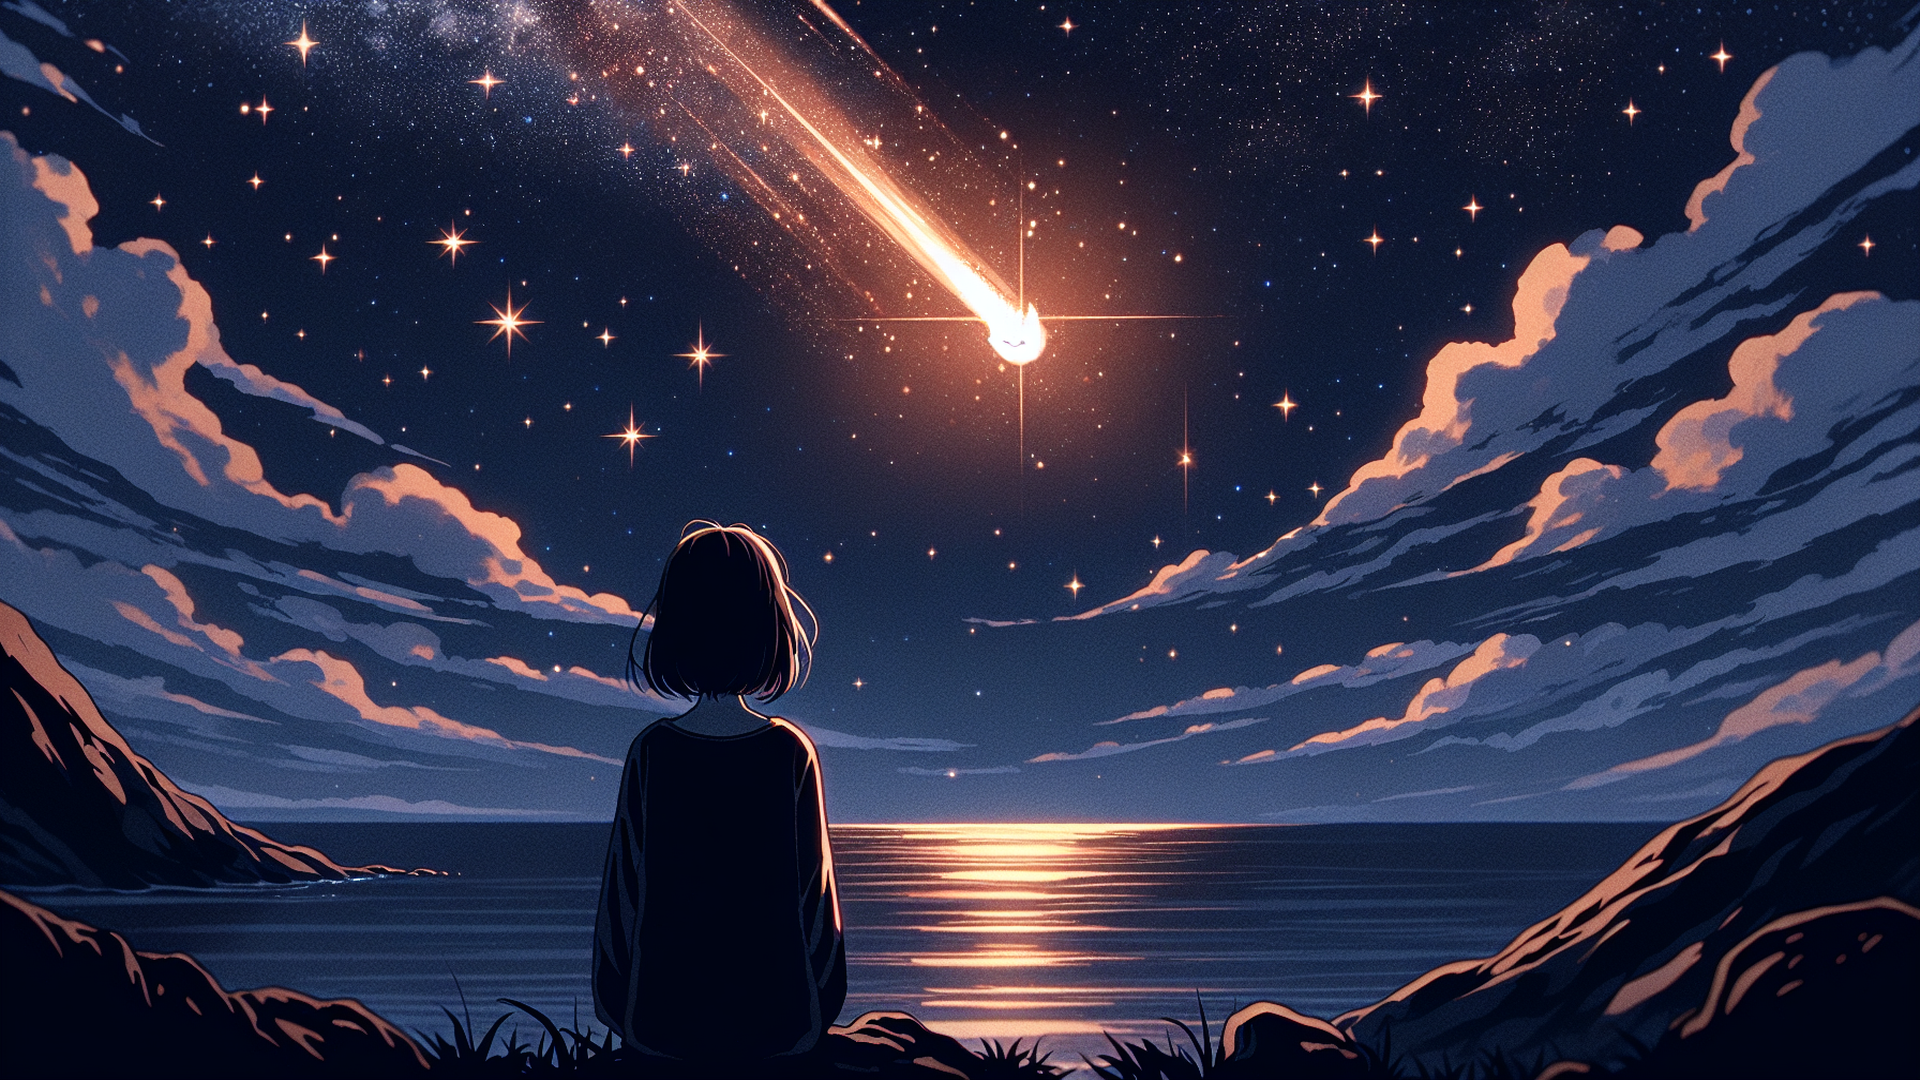

Image saved: ammunition/dalle3_chinese_scene_20251031_052141_1920x1080.png


In [176]:
# cell 8.2
from dotenv import load_dotenv
import openai
import requests
import os
from PIL import Image as PILImage
from IPython.display import Image as IPImage, display
from datetime import datetime

# --- Load API key from .env ---
load_dotenv()
openai.api_key = os.getenv("OPENAI_API")

# --- Prompt (Chinese) ---
prompt = (
    "一年後，他獨自抬頭，卻看到一顆流星劃過夜空，流星閃著她的微笑。"
    "畫面充滿溫柔與思念，夜空寧靜，星光閃爍，流星明亮且帶有溫暖的感覺。"
    "人物寂寞的背景，畫面不要有字，也不要出現女孩的臉")

# --- Timestamp for unique filenames ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# --- Generate image via DALL·E 3, size 1792x1024 ---
response = openai.images.generate(
    model="dall-e-3",
    prompt=prompt,
    n=1,
    size="1792x1024",
    quality="standard",
    response_format="url"
)

image_url = response.data[0].url

# --- Download image ---
os.makedirs("ammunition", exist_ok=True)
img_path = f"ammunition/dalle3_chinese_scene_{timestamp}.png"
img_data = requests.get(image_url).content
with open(img_path, "wb") as f:
    f.write(img_data)

# --- Resize to 1920x1080 ---
img = PILImage.open(img_path)
img_resized = img.resize((1920, 1080), PILImage.LANCZOS)
img_resized_path = f"ammunition/dalle3_chinese_scene_{timestamp}_1920x1080.png"
img_resized.save(img_resized_path)

# --- Show image in notebook ---
display(IPImage(filename=img_resized_path, width=480))
print(f"Image saved: {img_resized_path}")

In [180]:
# cell 9-14
import os
import shutil
import subprocess
import yaml
import pysubs2
import re
from PIL import Image, ImageDraw, ImageFont
import wave
from datetime import datetime, timedelta

# -- Load config and storyboard plan --
with open(os.path.join(subdir, "visual_plan.yaml"), encoding="utf-8") as f:
    visual_plan = yaml.safe_load(f)

project_title = config.get('project_title', config.get('title', '未設定'))
subtitle_font = config.get('subtitle_font', 'NotoSansCJKtc-Regular.otf')
subtitle_fontsize = config.get('subtitle_fontsize', 30)
video_resolution = config.get('video_resolution', [1920, 1080])
if isinstance(video_resolution, str):
    video_resolution = tuple(int(x.strip()) for x in video_resolution.split(',')[:2])
elif isinstance(video_resolution, (list, tuple)) and len(video_resolution) == 2:
    video_resolution = tuple(int(x) for x in video_resolution)
else:
    video_resolution = (1920, 1080)

ammunition_dir = os.path.join(main_dir, "ammunition")
bg_path = config.get('background', 'background.jpg')
thumb_file = config.get('thumbnail', 'thumbnail.jpg')
subtitle_path = os.path.join(subdir, "subtitle.ass")

print("\n=== STEP 1: Generate subtitle (ASS) file ===")
subs = pysubs2.SSAFile()
subs.info["playresx"], subs.info["playresy"] = video_resolution
style = subs.styles["Default"]
style.fontsize = subtitle_fontsize
style.alignment = pysubs2.Alignment.BOTTOM_CENTER
style.marginv = 10
style.fontname = "Noto Sans CJK TC"
style.primarycolor = 0xFFFFFF
style.fonts = [subtitle_font]

def clean_subtitle(text):
    return re.sub(r"[^\w\s\u4e00-\u9fff.,;:?!()（）「」《》'\"-]", "", text)

def smart_linebreak(text, maxlen=18):
    result = ""
    line = ""
    for char in text:
        line += char
        if len(line) >= maxlen and char in "，,。！？;；:：":
            result += line + "\\N"
            line = ""
    result += line
    return result

for i, item in enumerate(visual_plan):
    start = item["accum_duration"] - item["audio_duration"] if item["audio_duration"] else 0
    end = item["accum_duration"] if item["audio_duration"] else 0
    cleaned = clean_subtitle(item["sentence"])
    display_text = smart_linebreak(cleaned)
    subs.events.append(pysubs2.SSAEvent(
        start=int(start * 1000),
        end=int(end * 1000),
        text=display_text
    ))

subs.save(subtitle_path)
print(f"Saved subtitle file: {subtitle_path}")

print("\n=== STEP 2: Generate background and thumbnail ===")
first_bg = next((item.get('background') for item in visual_plan if item.get('background')), None)
if first_bg:
    bg_image_path = os.path.join(ammunition_dir, first_bg)
    if not os.path.exists(bg_image_path):
        print(f"⚠️ Warning: {bg_image_path} not found, using config background!")
        bg_image_path = bg_path
else:
    bg_image_path = bg_path

bg = Image.open(bg_image_path)
bg_fixed = bg.resize(video_resolution, resample=Image.LANCZOS)
background_youtube_path = os.path.join(subdir, "background_youtube.jpg")
bg_fixed.save(background_youtube_path)
print(f"Saved background image: {background_youtube_path}")

thumb = bg_fixed.copy()
draw = ImageDraw.Draw(thumb)
try:
    font = ImageFont.truetype(subtitle_font, 72)
except Exception:
    font = ImageFont.load_default()
draw.rectangle([0, 0, video_resolution[0], 160], fill=(0, 0, 0, 160))
draw.text((40, 40), project_title, font=font, fill=(255, 255, 255, 255))
thumbnail_path = os.path.join(subdir, thumb_file)
thumb.save(thumbnail_path)
print(f"Generated thumbnail: {thumbnail_path}")

print("\n=== STEP 3: Convert audio to WAV ===")
def convert_to_wav(infile, outfile):
    if not os.path.exists(infile):
        print(f"[ERROR] Missing file for WAV conversion: {infile}")
        return False
    r = subprocess.run([
        "ffmpeg", "-y", "-i", infile,
        "-acodec", "pcm_s16le", "-ar", "44100", "-ac", "1",
        outfile
    ], capture_output=True)
    if r.returncode != 0:
        print(r.stderr.decode())
        raise RuntimeError(f"Failed to convert {infile} to WAV.")
    print(f"Converted {infile} to {outfile}")
    return True

voice_mp3 = os.path.join(subdir, "voice.mp3")
voice_fixed_wav = os.path.join(subdir, "voice_fixed.wav")
if not convert_to_wav(voice_mp3, voice_fixed_wav):
    raise FileNotFoundError(f"Voice MP3 file missing: {voice_mp3}")
bgm_file = config.get('bgm', 'bgm.mp3')
bgm_fixed_wav = os.path.join(subdir, "bgm_fixed.wav")
if not convert_to_wav(bgm_file, bgm_fixed_wav):
    print(f"[WARNING] BGM file missing: {bgm_file}. Background music will not be mixed.")

for item in visual_plan:
    audio_mp3 = item['audio_file']
    audio_wav = os.path.splitext(audio_mp3)[0] + ".wav"
    convert_to_wav(audio_mp3, audio_wav)

print("\n=== STEP 4: Mix voice and BGM ===")
bgm_loud_volume = config.get("bgm_volume", 0.6)
output_audio_aac = os.path.join(subdir, "output_audio.aac")

if not os.path.exists(voice_fixed_wav):
    print(f"[ERROR] Voice WAV file missing: {voice_fixed_wav}. Cannot mix audio.")
elif not os.path.exists(bgm_fixed_wav):
    print(f"[WARNING] BGM WAV file missing: {bgm_fixed_wav}. Voice will be used alone.")
    # If BGM missing, just copy voice to output
    shutil.copy2(voice_fixed_wav, output_audio_aac)
    print(f"Copied voice audio as output (no BGM): {output_audio_aac}")
else:
    mix_cmd = [
        "ffmpeg", "-y",
        "-i", voice_fixed_wav,
        "-i", bgm_fixed_wav,
        "-filter_complex", f"[1:a]volume={bgm_loud_volume}[a1];[0:a][a1]amix=inputs=2:duration=first[aout]",
        "-map", "[aout]",
        "-acodec", "aac",
        output_audio_aac
    ]
    mix_result = subprocess.run(mix_cmd, capture_output=True)
    if mix_result.returncode != 0:
        print(mix_result.stderr.decode())
        raise RuntimeError("Failed to mix voice and bgm.")
    print(f"Mixed {output_audio_aac} with BGM volume set to {bgm_loud_volume}")

print("\n=== STEP 5: Create video, mux audio, burn subtitles ===")
audio_file = output_audio_aac  # <-- Use mixed audio!
if audio_file.endswith('.wav'):
    with wave.open(audio_file, "rb") as w:
        frames = w.getnframes()
        rate = w.getframerate()
        audio_duration = frames / float(rate)
else:
    probe2 = subprocess.run([
        "ffprobe", "-v", "error", "-show_entries",
        "format=duration", "-of", "default=noprint_wrappers=1:nokey=1", audio_file
    ], capture_output=True)
    audio_duration = float(probe2.stdout.decode().strip())
print(f"Audio duration: {audio_duration:.2f} seconds")

segment_files = []
for i, item in enumerate(visual_plan):
    seg_duration = item["audio_duration"] if item["audio_duration"] else 0
    if item["video_clip"]:
        video_src = os.path.join(ammunition_dir, item["video_clip"])
        seg_out = os.path.join(subdir, f"seg_{i:03d}.mp4")
        ffmpeg_cmd = [
            "ffmpeg", "-y", "-ss", "0", "-t", str(seg_duration),
            "-i", video_src,
            "-vf", f"scale={video_resolution[0]}:{video_resolution[1]}",
            "-c:v", "libx264", "-pix_fmt", "yuv420p", seg_out
        ]
        subprocess.run(ffmpeg_cmd, capture_output=True)
        segment_files.append(seg_out)
    elif item["background"]:
        img_src = os.path.join(ammunition_dir, item["background"])
        seg_out = os.path.join(subdir, f"seg_{i:03d}.mp4")
        ffmpeg_cmd = [
            "ffmpeg", "-y",
            "-loop", "1",
            "-i", img_src,
            "-t", str(seg_duration),
            "-vf", f"scale={video_resolution[0]}:{video_resolution[1]}",
            "-c:v", "libx264", "-pix_fmt", "yuv420p", seg_out
        ]
        subprocess.run(ffmpeg_cmd, capture_output=True)
        segment_files.append(seg_out)
    else:
        bg_img = os.path.join(subdir, "background_youtube.jpg")
        seg_out = os.path.join(subdir, f"seg_{i:03d}.mp4")
        ffmpeg_cmd = [
            "ffmpeg", "-y",
            "-loop", "1",
            "-i", bg_img,
            "-t", str(seg_duration),
            "-vf", f"scale={video_resolution[0]}:{video_resolution[1]}",
            "-c:v", "libx264", "-pix_fmt", "yuv420p", seg_out
        ]
        subprocess.run(ffmpeg_cmd, capture_output=True)
        segment_files.append(seg_out)

concat_list_path = os.path.join(subdir, "concat.txt")
with open(concat_list_path, 'w', encoding='utf-8') as f:
    for seg in segment_files:
        f.write(f"file '{seg}'\n")

main_video_path = os.path.join(subdir, "main_video.mp4")
concat_cmd = [
    "ffmpeg", "-y", "-f", "concat", "-safe", "0",
    "-i", concat_list_path,
    "-c", "copy", main_video_path
]
subprocess.run(concat_cmd, capture_output=True)
print(f"Main video segments concatenated: {main_video_path}")

main_video_with_audio_path = os.path.join(subdir, "main_video_with_audio.mp4")
mux_cmd = [
    "ffmpeg", "-y",
    "-i", main_video_path,
    "-i", audio_file,  # <-- Use mixed audio!
    "-c:v", "copy",
    "-c:a", "aac",
    main_video_with_audio_path
]
subprocess.run(mux_cmd, capture_output=True)
print(f"Main video with audio created: {main_video_with_audio_path}")

final_video_path = os.path.join(subdir, "final_video.mp4")
burn_cmd = [
    "ffmpeg", "-y",
    "-i", main_video_with_audio_path,
    "-vf", f"ass={subtitle_path}",
    "-c:v", "libx264", "-c:a", "aac",
    final_video_path
]
subprocess.run(burn_cmd, capture_output=True)
print(f"Final video with burned subtitles: {final_video_path}")

print("\n=== STEP 6: Final video assembly, fade out, archiving ===")
os.chdir(main_dir)
background_img = os.path.join(subdir, "background_youtube.jpg")
required_files = [background_img, main_video_with_audio_path, subtitle_path]
missing = []
for fname in required_files:
    if not os.path.exists(fname):
        print(f"警告：缺少檔案 {fname}")
        missing.append(fname)
if missing:
    raise FileNotFoundError(f"缺少必要檔案：\n" + "\n".join(missing))

background_img_main = os.path.join(main_dir, os.path.basename(background_img))
main_video_with_audio_main = os.path.join(main_dir, os.path.basename(main_video_with_audio_path))
subtitle_file_main = os.path.join(main_dir, os.path.basename(subtitle_path))
shutil.copy(background_img, background_img_main)
shutil.copy(main_video_with_audio_path, main_video_with_audio_main)
shutil.copy(subtitle_path, subtitle_file_main)

pause_video = os.path.join(main_dir, "pause_video.mp4")
pause_cmd = [
    "ffmpeg", "-y",
    "-loop", "1",
    "-i", background_img_main,
    "-t", "2",
    "-c:v", "libx264",
    "-pix_fmt", "yuv420p",
    pause_video
]
subprocess.run(pause_cmd, capture_output=True)

concat_list = os.path.join(main_dir, "concat_list_final.txt")
with open(concat_list, "w", encoding="utf-8") as f:
    f.write(f"file '{main_video_with_audio_main}'\n")
    f.write(f"file '{pause_video}'\n")
output_with_pause = os.path.join(main_dir, "output_with_pause.mp4")
concat_cmd = [
    "ffmpeg", "-y",
    "-f", "concat", "-safe", "0", "-i", concat_list,
    "-c", "copy", output_with_pause
]
subprocess.run(concat_cmd, capture_output=True)

probe = subprocess.run([
    "ffprobe", "-v", "error", "-show_entries",
    "format=duration", "-of", "default=noprint_wrappers=1:nokey=1", main_video_with_audio_main
], capture_output=True)
duration_str = probe.stdout.decode().strip()
if not duration_str:
    print(f"ffprobe 輸出為空，請檢查影片檔案：{main_video_with_audio_main}")
    print("ffprobe stderr:", probe.stderr.decode())
    raise ValueError(f"無法取得影片長度：{main_video_with_audio_main}")
audio_duration = float(duration_str)
extra_pause = 2
total_duration = audio_duration + extra_pause

dt_utc_now = datetime.utcnow() + timedelta(hours=8)
outname_no_sub = os.path.join(main_dir, f"output_{dt_utc_now.strftime('%Y%m%d_%H%M%S')}_nosub.mp4")
fade_cmd = [
    "ffmpeg", "-y",
    "-i", output_with_pause,
    "-vf", f"fade=t=out:st={total_duration-1}:d=1",
    "-af", f"afade=t=out:st={total_duration-1}:d=1",
    "-c:v", "libx264", "-c:a", "aac", "-pix_fmt", "yuv420p", outname_no_sub
]
fade_result = subprocess.run(fade_cmd, capture_output=True)
if fade_result.returncode != 0:
    print(fade_result.stderr.decode())
    raise RuntimeError("Failed to apply fade out to video.")

font_size = 18
final_video_main = os.path.join(main_dir, f"final_{project_title}.mp4")
subtitle_file_ffmpeg = os.path.basename(subtitle_file_main).replace('\\', '/')
burn_cmd = [
    "ffmpeg", "-y",
    "-i", outname_no_sub,
    "-vf", f"subtitles='{subtitle_file_ffmpeg}':force_style='Fontsize={font_size}'",
    "-c:a", "copy", "-c:v", "libx264", "-pix_fmt", "yuv420p", final_video_main
]
burn_result = subprocess.run(burn_cmd, capture_output=True)
if burn_result.returncode != 0:
    print(burn_result.stderr.decode())
    raise RuntimeError("Failed to burn subtitles into video.")

final_video_subdir = os.path.join(subdir, f"final_{project_title}.mp4")
shutil.copy(final_video_main, final_video_subdir)
print(f"Final video saved in:\n  {final_video_main}\n  {final_video_subdir}")

for fname in [
    "pause_video.mp4", "concat_list_final.txt", "output_with_pause.mp4", os.path.basename(outname_no_sub),
    os.path.basename(background_img_main), os.path.basename(main_video_with_audio_main), os.path.basename(subtitle_file_main)
]:
    try:
        os.remove(os.path.join(main_dir, fname))
    except Exception:
        pass

print("="*40)
print(f"專案名稱: {project_title}")
print(f"Current subdir: {subdir}")
print(f"目前工作目錄：{os.getcwd()}")
print("="*40)


=== STEP 1: Generate subtitle (ASS) file ===
Saved subtitle file: C:\Users\flyre\projects\myvideoprojects\20251031_test\subtitle.ass

=== STEP 2: Generate background and thumbnail ===
Saved background image: C:\Users\flyre\projects\myvideoprojects\20251031_test\background_youtube.jpg
Generated thumbnail: C:\Users\flyre\projects\myvideoprojects\20251031_test\thumbnail.jpg

=== STEP 3: Convert audio to WAV ===
Converted C:\Users\flyre\projects\myvideoprojects\20251031_test\voice.mp3 to C:\Users\flyre\projects\myvideoprojects\20251031_test\voice_fixed.wav
Converted bgm.mp3 to C:\Users\flyre\projects\myvideoprojects\20251031_test\bgm_fixed.wav

=== STEP 4: Mix voice and BGM ===
Mixed C:\Users\flyre\projects\myvideoprojects\20251031_test\output_audio.aac with BGM volume set to 0.3

=== STEP 5: Create video, mux audio, burn subtitles ===
Audio duration: 6.25 seconds
Main video segments concatenated: C:\Users\flyre\projects\myvideoprojects\20251031_test\main_video.mp4
Main video with audio c

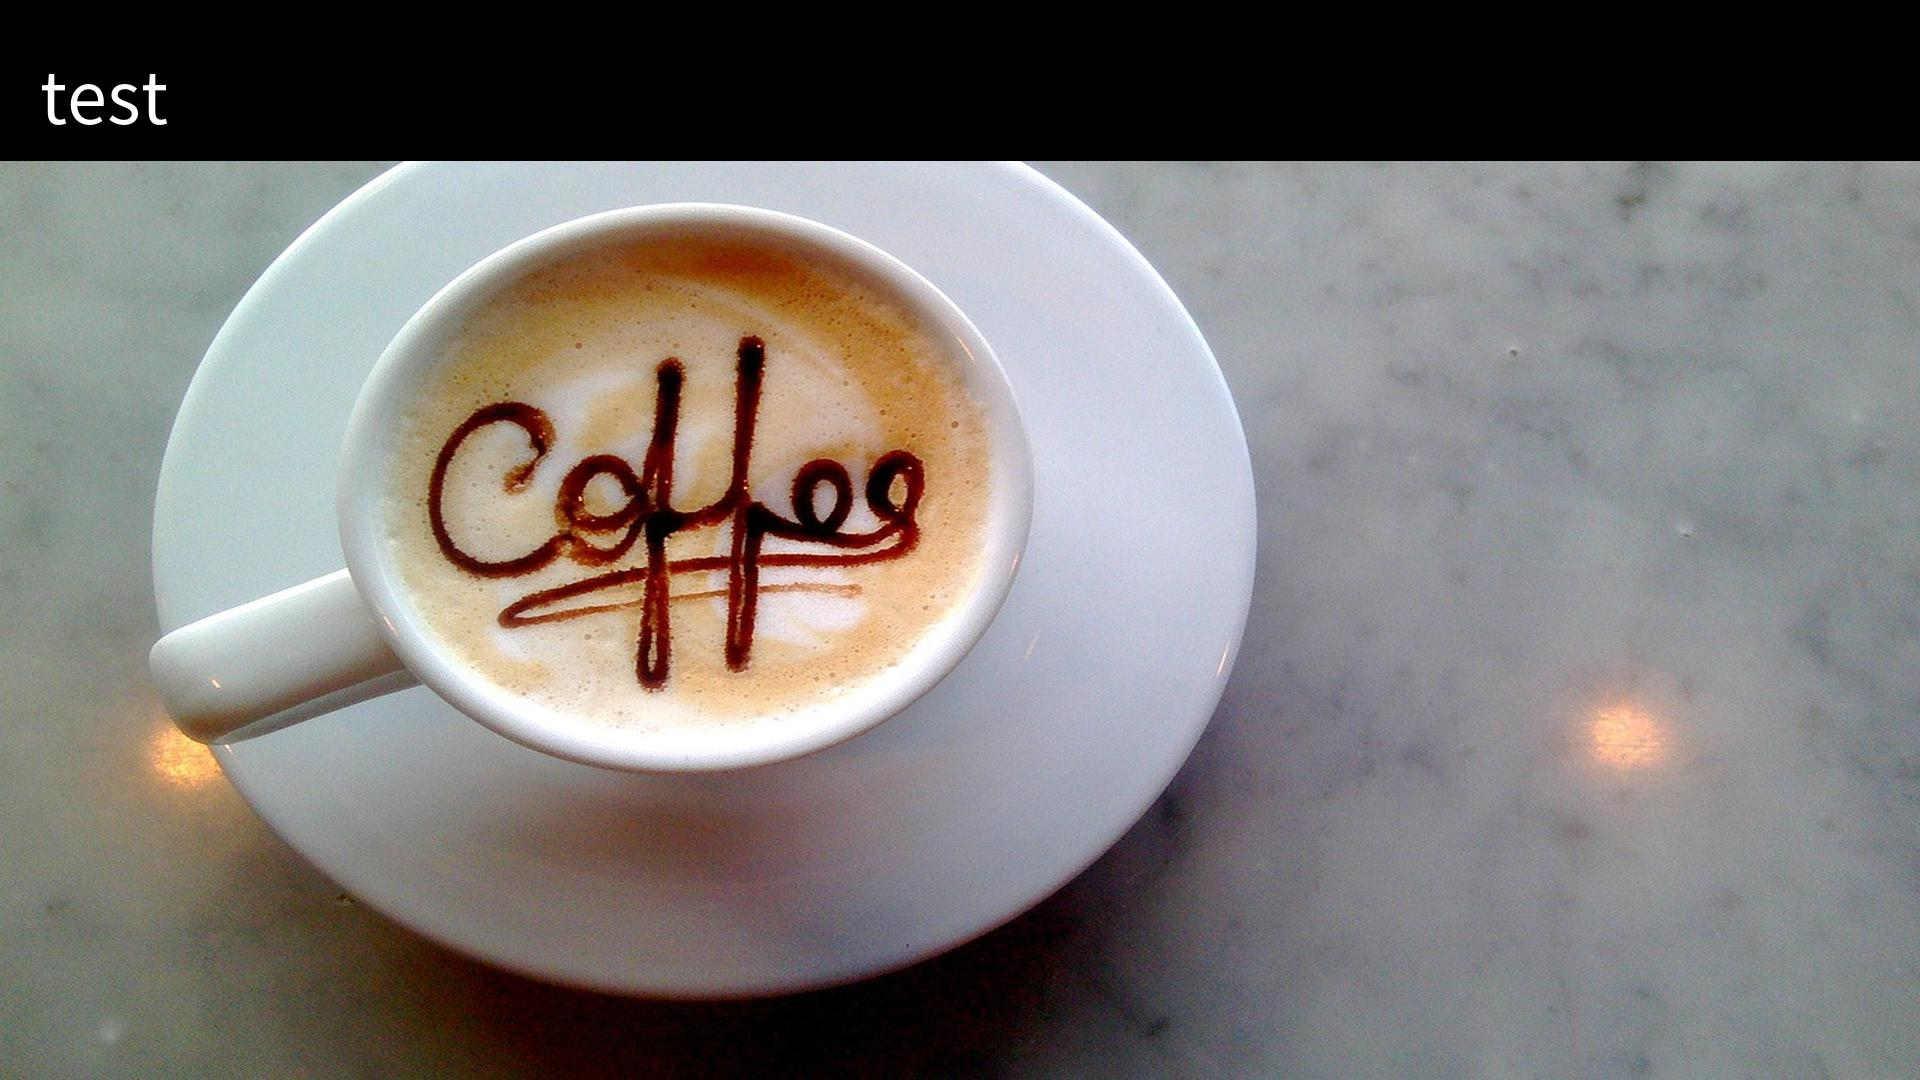

Exported metadata for YouTube upload: C:\Users\flyre\projects\myvideoprojects\20251031_test\youtube_metadata.txt
專案名稱: test
Current subdir: C:\Users\flyre\projects\myvideoprojects\20251031_test
目前工作目錄：C:\Users\flyre\projects\myvideoprojects


In [178]:
# cell 15
from IPython.display import Video as ShowVideo, Image as ShowImage
import os
from datetime import datetime, timedelta

# --- Use consistent variables and paths ---
project_title = config.get('project_title', config.get('title', 'test'))
project_author = config.get('project_author', config.get('author', '未設定'))
attribution = config.get('attribution', '')
thumbnail_name = config.get('thumbnail', 'thumbnail.jpg')
thumbnail_path = os.path.join(subdir, thumbnail_name)

final_video_name = f"final_{project_title}.mp4"
outname_final = os.path.join(main_dir, final_video_name)

# --- Display thumbnail and final video ---
if os.path.exists(thumbnail_path):
    display(ShowImage(thumbnail_path))
else:
    print(f"Thumbnail not found: {thumbnail_path}")

if os.path.exists(outname_final):
    display(ShowVideo(url=outname_final))
else:
    print(f"Final video not found: {outname_final}")

# --- Export YouTube metadata ---
youtube_metadata_path = os.path.join(subdir, "youtube_metadata.txt")
subtitle_srt_path = os.path.join(subdir, "subtitle.srt")  # ASS to SRT conversion not shown, but path reserved
dt_utc_now = datetime.utcnow() + timedelta(hours=8)

with open(youtube_metadata_path, "w", encoding="utf-8") as meta:
    meta.write(f"Title: {project_title}\n")
    meta.write(f"Author: {project_author}\n")
    meta.write(f"Date: {dt_utc_now.strftime('%Y-%m-%d')}\n")
    meta.write(f"Description: {attribution}\n")
    meta.write(f"Subtitle SRT: {subtitle_srt_path}\n")
    meta.write(f"Thumbnail: {thumbnail_path}\n")

print(f"Exported metadata for YouTube upload: {youtube_metadata_path}")
print("="*40)
print(f"專案名稱: {project_title}")
print(f"Current subdir: {subdir}")
print(f"目前工作目錄：{os.getcwd()}")
print("="*40)